In [1]:
import numpy as np
from neural_network.layer import *
from neural_network.net import *
from queue import Queue
import matplotlib.pyplot as plt
from tqdm import tqdm
from neural_network.trainutils import Dataset, PCADataset, train_test_split
import os
import seaborn as sns

In [2]:
num_epochs = 2500
linear_layer_downscale_factor=2
file_name = "hd_pca_epoch2500"

In [3]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "cmu+face+images", "faces")
dataset = PCADataset(face_dir)

In [4]:
input_shape = dataset[0][0].shape[-2]
print(input_shape)

68


In [5]:
train, validation, test = train_test_split(dataset, (0.8, 0.0, 0.2))

In [6]:
linear1 = Linear(input_shape, input_shape//linear_layer_downscale_factor)
relu1 = ReLU(linear1)
linear2 = Linear(input_shape//linear_layer_downscale_factor, input_shape//linear_layer_downscale_factor**2, relu1)
relu2 = ReLU(linear2)
linear3 = Linear(input_shape//linear_layer_downscale_factor**2, input_shape//linear_layer_downscale_factor**3, relu2)
relu3 = ReLU(linear3)
linear4 = Linear(input_shape//linear_layer_downscale_factor**3, input_shape//linear_layer_downscale_factor**4, relu3)
relu4 = ReLU(linear4)
linear5 = Linear(input_shape//linear_layer_downscale_factor**4, len(dataset.keys), relu4)
softmaxlayer = Softmax(linear5)
loss_layer = CrossEntropy(softmaxlayer)

model = NeuralNetwork(linear1, softmaxlayer, loss_layer)

In [7]:
print(model.n_layers)

print("Forward order:")
for layer in model._forward_order:
    print(layer)

print("\nBackward order:")
for layer in model._backward_order:
    print(layer)

11
Forward order:
Linear: (68, 1) -> (34, 1)
ReLU
Linear: (34, 1) -> (17, 1)
ReLU
Linear: (17, 1) -> (8, 1)
ReLU
Linear: (8, 1) -> (4, 1)
ReLU
Linear: (4, 1) -> (4, 1)
Softmax
CrossEntropy

Backward order:
CrossEntropy
Softmax
Linear: (4, 1) -> (4, 1)
ReLU
Linear: (8, 1) -> (4, 1)
ReLU
Linear: (17, 1) -> (8, 1)
ReLU
Linear: (34, 1) -> (17, 1)
ReLU
Linear: (68, 1) -> (34, 1)


In [8]:
loss_array = []
mean_epoch_loss = 0
pbar = tqdm(range(num_epochs))
for i in pbar:
    epoch_loss = 0
    for j, (data, label) in enumerate(train):
        data = data.reshape(-1, 1)
        out = model.forward(data)
        #print(out)
        loss = model.loss_layer.forward(out, label)
        epoch_loss += loss
        model.backward()
        model.step()
        #pbar2.set_description(f"[{i}]:{j}/{len(train)} (cur={epoch_loss}, prevmean={mean_epoch_loss})")
    mean_epoch_loss = epoch_loss / len(train)
    #pbar2.set_postfix(mean_epoch_loss)
    loss_array.append(mean_epoch_loss)
    pbar.set_description(float(epoch_loss))

[0]:498/499 (cur=[793.32658739], prevmean=0): : 499it [00:00, 2325.97it/s]
[1]:206/499 (cur=[301.72098132], prevmean=[1.58983284]): : 0it [00:00, ?it/s]

[1]:498/499 (cur=[714.9852371], prevmean=[1.58983284]): : 499it [00:00, 2068.31it/s] 
[2]:498/499 (cur=[699.06364678], prevmean=[1.43283615]): : 499it [00:00, 1956.73it/s]
[3]:498/499 (cur=[692.04453397], prevmean=[1.40092915]): : 499it [00:00, 1994.06it/s]
[4]:498/499 (cur=[687.06066836], prevmean=[1.38686279]): : 499it [00:00, 2077.45it/s]
[5]:498/499 (cur=[682.58048298], prevmean=[1.37687509]): : 499it [00:00, 2012.99it/s]
[6]:498/499 (cur=[677.89920509], prevmean=[1.36789676]): : 499it [00:00, 1834.85it/s]
[7]:498/499 (cur=[672.38375784], prevmean=[1.35851544]): : 499it [00:00, 2126.37it/s]
[8]:498/499 (cur=[665.60405491], prevmean=[1.34746244]): : 499it [00:00, 2015.04it/s]
[9]:498/499 (cur=[657.68854376], prevmean=[1.33387586]): : 499it [00:00, 1926.82it/s]
[10]:498/499 (cur=[647.54164657], prevmean=[1.31801311]): : 499it [00:00, 2213.91it/s]
[11]:498/499 (cur=[634.74661552], prevmean=[1.29767865]): : 499it [00:00, 2026.31it/s]
[12]:498/499 (cur=[619.60876237], prevmean=[1.272037

KeyboardInterrupt: 

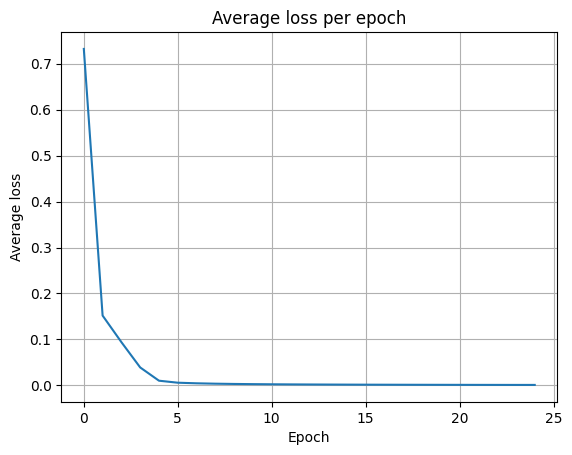

In [ ]:
plt.plot(loss_array)
plt.grid()
plt.title("Average loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.savefig(f"plots/{file_name}_loss.pdf", format="pdf", bbox_inches="tight")

accuracy: 1.0


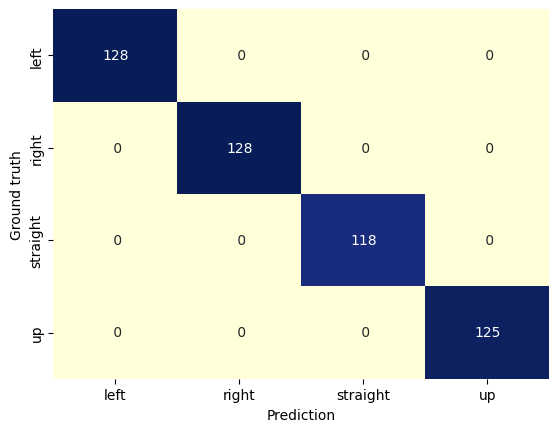

In [ ]:
confusion_matrix = np.zeros(shape=[len(dataset.keys)]*2)
for data, label in train:
    data = data.reshape(-1, 1)
    out = model.forward(data)
    #print(out)
    loss = model.loss_layer.forward(out, label)
    confusion_matrix[np.argmax(label), np.argmax(out)] += 1
    epoch_loss += loss
print(f"accuracy: {confusion_matrix.trace()/confusion_matrix.sum()}")

plt.figure()
sns.heatmap(confusion_matrix.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
#plt.title(f"")
plt.show()
plt.savefig(f"plots/{file_name}_train_confmat.pdf", format="pdf", bbox_inches="tight")

accuracy: 0.952


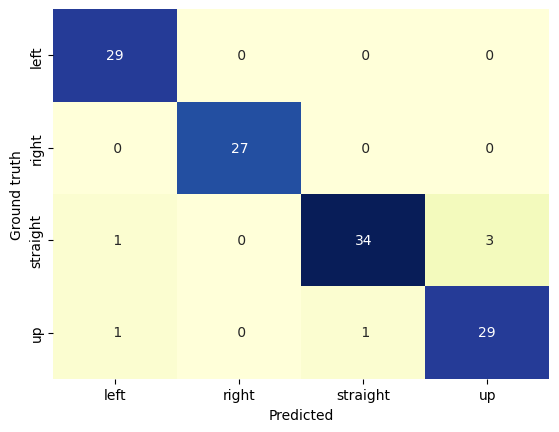

In [ ]:
confusion_matrix = np.zeros(shape=[len(dataset.keys)]*2)
for data, label in test:
    data = data.reshape(-1, 1)
    out = model.forward(data)
    #print(out)
    loss = model.loss_layer.forward(out, label)
    confusion_matrix[np.argmax(label), np.argmax(out)] += 1
    epoch_loss += loss
print(f"accuracy: {confusion_matrix.trace()/confusion_matrix.sum()}")

plt.figure()
sns.heatmap(confusion_matrix.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
#plt.title(f"test NN confusion matrix")
plt.show()
plt.savefig(f"plots/{file_name}_test_confmat.pdf", format="pdf", bbox_inches="tight")

In [ ]:
import pickle

In [ ]:
with open(f"bin/{file_name}.pickle", "wb") as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(f"bin/{file_name}.pickle", "wb") as file:
    pickle.dump(loss_array, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(loss_array[:-2])

[array([0.73233082]), array([0.15178772]), array([0.09397095]), array([0.0388785]), array([0.01001533]), array([0.00564794]), array([0.00435584]), array([0.00351416]), array([0.00294721]), array([0.00253766]), array([0.00222097]), array([0.00197575]), array([0.00177682]), array([0.00161704]), array([0.00148068]), array([0.00136495]), array([0.00126735]), array([0.00117987]), array([0.00110405]), array([0.0010379]), array([0.0009776]), array([0.00092311]), array([0.00087412])]
